# POISSON REGRESSION
BS Vương Kiến Thanh

Chào anh chị em, hôm nay tôi xin giới thiệt một mô hình cũng khá phổ biến là **Poisson regression**. Nó cũng là một thành viên trong họ Generalized Linear Model (GLM). Đặc điểm của nó là:
- Likelihood là phân phối Poisson. Nó là phân phối rời rạc, được dùng để mô hình hoá cho dạng dữ liệu số đếm.  Thực ra phân phối Poisson là một trường hợp đặc biệt của Binomial khi $n$ quá lớn và $p$ quá nhỏ. Khi đó trung bình của phân phối sẽ bằng với phương sai của phân phối, cũng bằng tham số rate $\lambda$ của Poisson ( $\mu = \sigma^2 = \lambda$ ).
- Link function là hàm logarith. Mục đích là để $\lambda$ luôn dương.

Tổng quát, Poisson regression có dạng:

$$ \begin{aligned}
\text{y} &= \text{Poisson}(\lambda)\\
\log(\lambda) &= \alpha + \sum\beta x\\
\end{aligned}$$

---

# Thực hành
Ví dụ hôm nay, chúng ta sẽ mô hình hoá số lượng bệnh nhân ngoại trú trong năm tại bệnh viện ABC.  
Dữ liệu là số lượng khám ngoại trú mỗi ngày từ ngày 1-1-2019 đến 30-11-2019 (không có tháng 12)

In [1]:
import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import datetime as dt
import jax.numpy as jnp
from jax import lax, random, vmap

import numpyro
import numpyro.distributions as dist
import numpyro.optim as optim
from numpyro.diagnostics import print_summary
from numpyro.infer import Predictive, SVI, Trace_ELBO
from numpyro.infer.autoguide import AutoLaplaceApproximation
az.style.use('fivethirtyeight')

In [2]:
df = pd.read_csv("./outpatient_count_2019.csv", index_col=0)
df.index = pd.to_datetime(df.index, format="%Y%m%d")
df

,count
date,
2019-01-01,691
2019-01-02,1444
2019-01-03,1304
2019-01-04,1250
2019-01-05,1097
...,...
2019-11-26,1759
2019-11-27,1627
2019-11-28,1800


Trước khi dùng Poisson, ta phải xác nhận các giả định của nó:

- [x] Đây không phải time series, tức là mẫu quan sát sau không phụ thuộc và quan sát trước đó. Rõ ràng mặc dù index của dữ liệu là thời gian, nhưng mỗi quan sát là độc lập với nhau.
- [x] Các giá trị outcome là số rời rạc (không chồng lắp), và luôn luôn dương.

### Khảo sát


<AxesSubplot:>

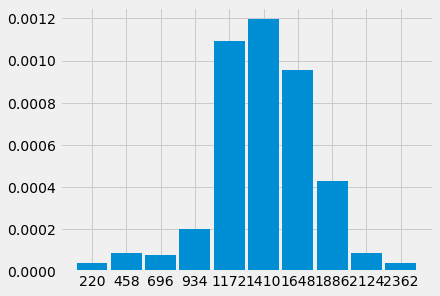

In [3]:
az.plot_dist(df['count'])

-> Phân phối của kết cục gần giống như pp normal nhưng hơi left-skewed.

Thực vậy , trong trường hợp lambda đủ lớn, $y$ sẽ có phân phối gần giống normal(loc=$\lambda$, scale=$\sqrt{\lambda}$).

Tôi sẽ dựng mô hình như sau:

$$ \begin{aligned}
\text{y} &= \text{Poisson}(\lambda)\\
\log(\lambda) &= \text{aq}_{\text{quarter}} + \text{aw}_{\text{weekday}}\\
\end{aligned}$$

trong đó:
- quarter là category variable, đại diện cho các quý trong năm, có giá trị 1,2,3,4.
- weekday cũng là category variable, đại diện cho các ngày trong tuần, có giá trị 0->6 : Thứ hai -> Chủ nhật.
- aq, aw lần lượt là các intercept của quarter và weekday.

Cần chú ý rằng, những variable đó là thuộc dạng nhóm (category), không phải ordinal, tức là không có sự cao thấp giữa các giá trị. Do đó, ta không thể đặt hệ số cho chúng, mà phải dùng intercept cho từng nhóm.

In [4]:
df["quarter"] = 0
df["quarter"][df.index < dt.datetime(2019,4,1)] = 1
df["quarter"][(df.index >= dt.datetime(2019,4,1)) & (df.index < dt.datetime(2019,7,1)) ] = 2
df["quarter"][(df.index >= dt.datetime(2019,7,1)) & (df.index < dt.datetime(2019,10,1)) ] = 3
df["quarter"][df.index >= dt.datetime(2019,10,1)] = 4

df["weekday"] = df.index.weekday

df

,count,quarter,weekday
date,,,
2019-01-01,691,1,1
2019-01-02,1444,1,2
2019-01-03,1304,1,3
2019-01-04,1250,1,4
2019-01-05,1097,1,5
...,...,...,...
2019-11-26,1759,4,1
2019-11-27,1627,4,2
2019-11-28,1800,4,3


In [5]:
date_dict = {
    0: 'Thứ hai',
    1: 'Thứ ba',
    2: 'Thứ tư',
    3: 'Thứ năm',
    4: 'Thứ sáu',
    5: 'Thứ bảy',
    6: 'Chủ nhật'
}

### Fit mô hình

In [6]:
def model(quarter, weekday, count=None):
    aq = numpyro.sample("aq", dist.Normal(0, 10).expand([4]))
    aw = numpyro.sample("aw", dist.Normal(0, 10).expand([7]))
    lambda_ = numpyro.deterministic("lambda", jnp.exp(aq[quarter-1] + aw[weekday]))
    numpyro.sample("C", dist.Poisson(lambda_), obs=count)

Posterior được tìm ra bằng kỹ thuật SVI. Ở đây tôi giả định posterior đều là phân phối normal, thông qua việc đặt guide là `AutoLaplaceApproximation`.

In [7]:
guide = AutoLaplaceApproximation(model)
svi = SVI(
    model,
    guide,
    optim.Adam(1),
    Trace_ELBO(),
    count=df["count"].values,
    quarter=df["quarter"].values,
    weekday=df["weekday"].values
)
param, losses = svi.run(random.PRNGKey(0), 1000)
post = guide.sample_posterior(random.PRNGKey(1), param, (1000,))
predictive = Predictive(model, post, return_sites=['C'])

100%|██████████| 1000/1000 [00:01<00:00, 514.02it/s, init loss: 2891572.0000, avg. loss [951-1000]: 7638.5093]


### Biểu đồ Posterior
Posterior cho *từng intercept* cho *từng nhóm* là normal đúng với giả định của `AutoLaplaceApproximation`.

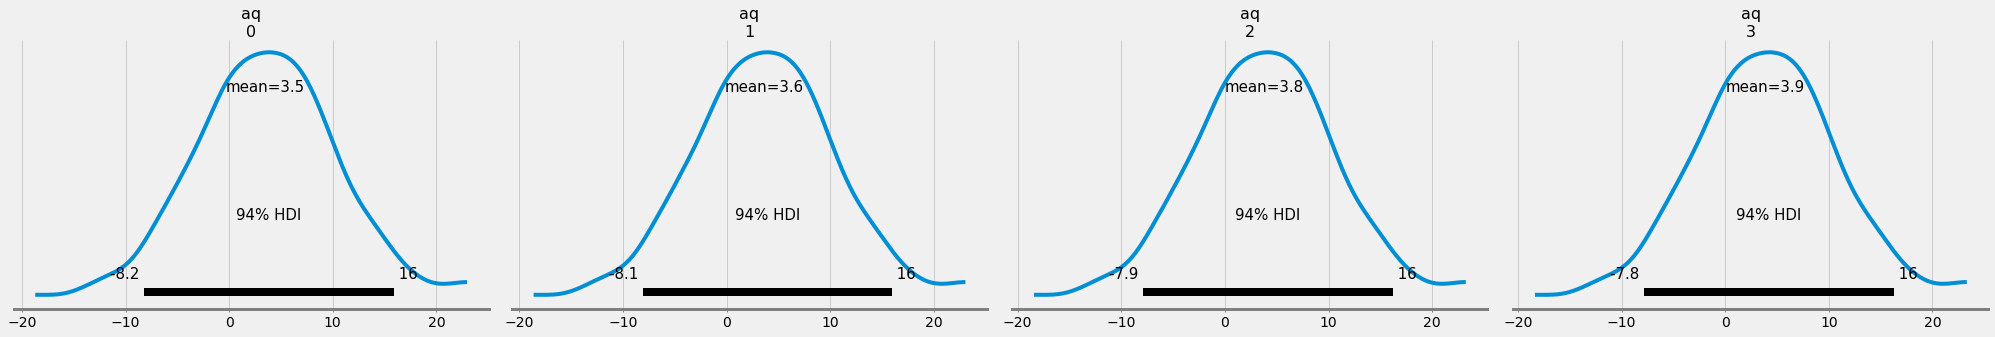

In [8]:
az.plot_posterior({"aq": [post['aq']]});

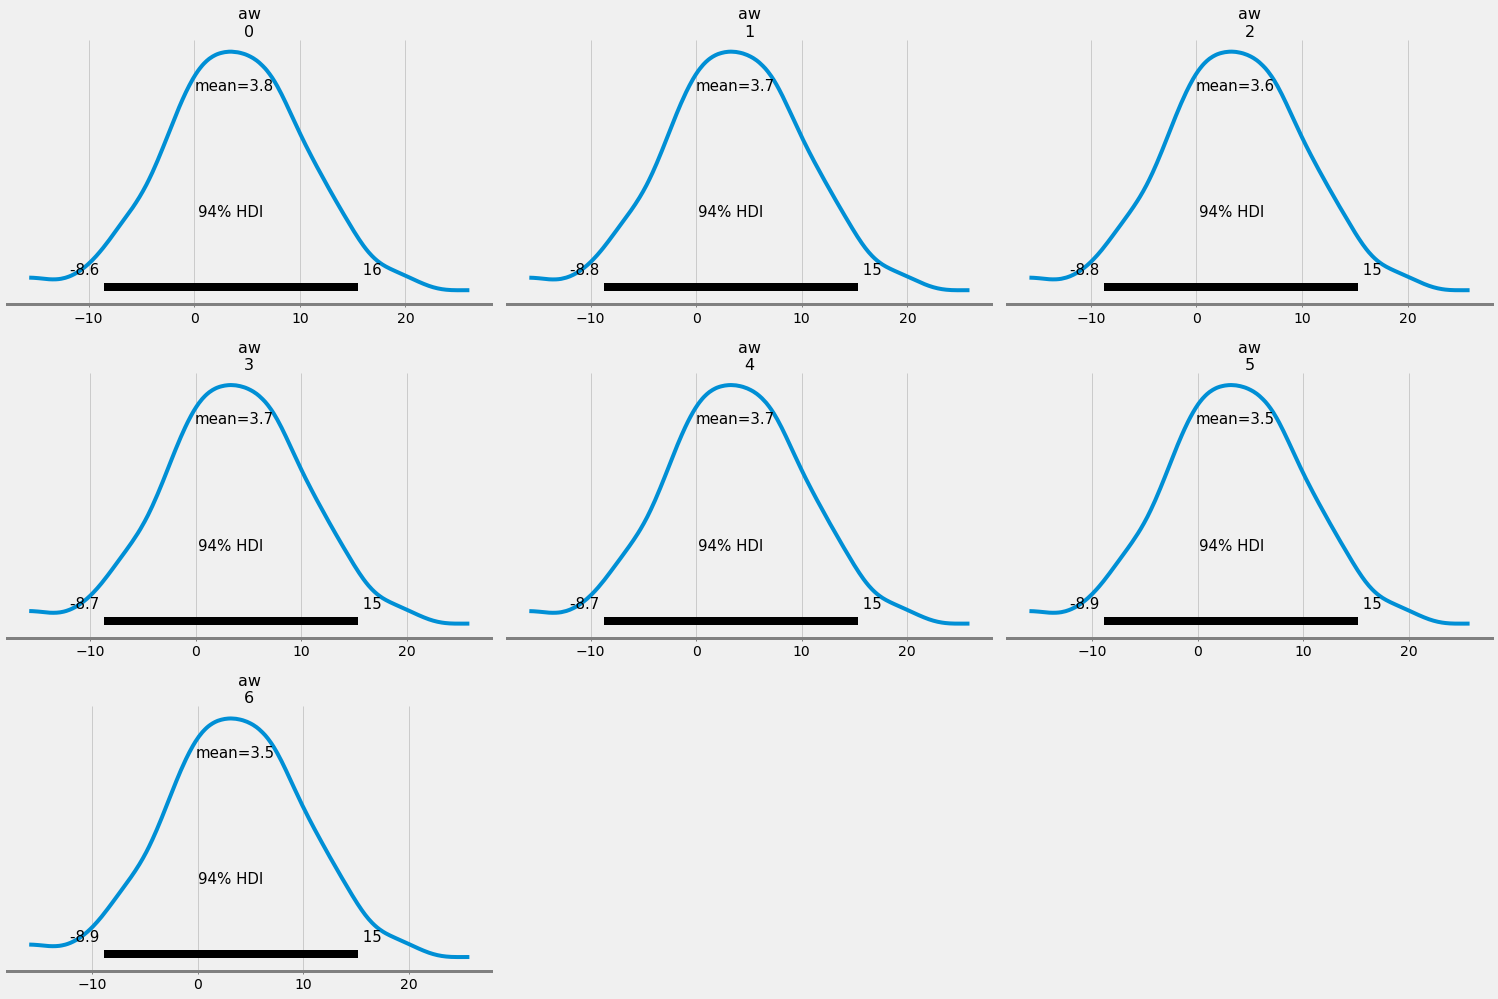

In [9]:
az.plot_posterior({"aw": [post['aw']]});

### Diễn giải mô hình
Để diễn giải mô hình chứa biến thuộc dạng category, chúng ta có thể chia ra từng biểu đồ cho từng nhóm, hoặc ghép chúng lại với màu khác nhau.

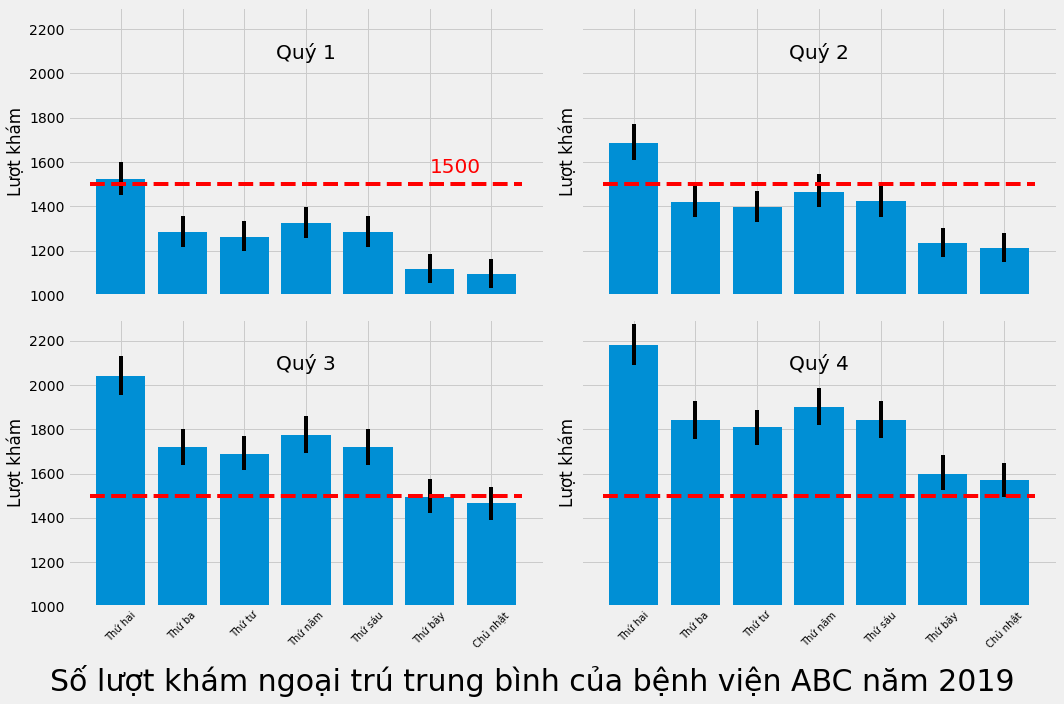

In [10]:
fig, axs = plt.subplots(2,2, figsize=(15,10), sharey=True, sharex=True, subplot_kw={"ylim":(1000,2300)})
for i, ax in enumerate(axs.flatten()):
    count_pred = vmap(
        lambda wd: predictive(random.PRNGKey(2), quarter=i+1, weekday=wd)["C"])(jnp.arange(7))
    count_mean = jnp.mean(count_pred, axis=1)
    count_CI = jnp.quantile(count_pred, jnp.array([0.025, 0.975]), axis=1)
    ax.bar(jnp.arange(7), count_mean, yerr=jnp.abs(count_CI-count_mean))
    ax.set(xticks=jnp.arange(7), xticklabels=date_dict.values(), ylabel="Lượt khám")
    ax.hlines(1500, -0.5, 6.5, linestyle="--", colors='r')
    ax.set_title(f"Quý {i+1}", y=0.8)
    ax.tick_params(axis="x", labelsize=10, labelrotation=45)
axs[0,0].annotate("1500", (5, 1550), size=20, color="r")
plt.suptitle("Số lượt khám ngoại trú trung bình của bệnh viện ABC năm 2019", size=30, y=0)
plt.tight_layout();

# Tổng kết
Poisson regression là một mô hình GLM với những giả định đơn giản. Chúng ta có thể mở rộng thêm mô hình này bằng cách thêm những giả định khác, tạo thành **multilevel model**. Trong đó, có một trường hợp đặc biệt là bernoulli + poisson =  **ZeroInflatedPoisson regresion**, và tôi sẽ giới thiệu nó trong bài sau.